Assignment 1 Natural Language Processing
Name : Prince Kumar
Roll no : 23
Msc Data science

In [ ]:
import json
import pandas as pd
import os

In [ ]:
!pip install PyDrive

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
!pip install Kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"prncekumar","key":"ce0a7662c3494071fe8953d3fedb556f"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d allen-institute-for-ai/CORD-19-research-challenge

100% 8.00G/8.02G [03:08<00:00, 82.1MB/s]
100% 8.02G/8.02G [03:08<00:00, 45.7MB/s]


In [ ]:
from zipfile import ZipFile
file_name = "CORD-19-research-challenge.zip"
with ZipFile(file_name, "r") as zip:
  zip.extractall()
  

In [ ]:
# this finds our json files
path_to_json = '/content/document_parses/pdf_json'
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
json_files = json_files[:56628]

In [ ]:
len(json_files)


56628

In [ ]:
# here I define my pandas Dataframe with the columns I want to get from the json
# jsons_data = pd.DataFrame(columns=['country', 'city', 'long/lat'])
jsons_data = pd.DataFrame(columns=['paper_id', 'abstract', 'body_text'])

id2abstract = []
# we need both the json and an index number so use enumerate()
for index, js in enumerate(json_files[:1000]):     # Using 1000 files only to reduce memory load and resources
    with open(os.path.join(path_to_json, js)) as json_file:
        json_text = json.load(json_file)

        # here you need to know the layout of your json and each json has to have
        # the same structure (obviously not the structure I have here)
        paper_id = json_text['paper_id']
#         abstract = json_text['abstract'][0]['text']
        abstract=''
        for entry in json_text['abstract']:
                abstract += entry['text']
        id2abstract.append({paper_id:abstract})
                #abstract.append(entry['text'])
        body_text=""
        for entry in json_text['body_text']:
                body_text += entry['text']
                #body_text.append(entry['text'])
                
        # here I push a list of data into a pandas DataFrame at row given by 'index'
        jsons_data.loc[index] = [paper_id, abstract, body_text]

# now that we have the pertinent json data in our DataFrame let's look at it
print(jsons_data)

In [ ]:
# Display the dataframe
jsons_data

,paper_id,abstract,body_text
0,173417343f37c299df8c0fe888cf316b78630e16,"Inflammation, immunity and potential target th...","As of January 26, 2021, a sum of 100,346,160 c..."
1,4b711ac332f15ee6478e2e0bf0cc5353b569408c,,Severe acute respiratory syndrome (SARS) coron...
2,044121b9836211da07d369e926f1eabd287efb8a,,Argumentation is considered an effective tool ...
3,19591d13b1530344fb152de55901f77b043b6a1f,The pandemic of COVID-19 has affected many cou...,globe. Except for ongoing cycles or fertility ...
4,397176c0ed002268a316e8a0051edb16400c5ef1,,"The sphingomyelin pathway is a ubiquitous, evo..."
...,...,...,...
602,0b9e7451552da6af9d62fb0cb98958f17087f7b4,Background: The COVID-19 pandemic lockdown (CP...,The current COVID-19 pandemic challenges diagn...
603,475f6dbf8cec2ae10143d7c45043fe0795305461,,A small cluster of cases of the disease now kn...
604,36bba2ce2418fefda9e322a0b4eaa28bc349082e,,La prise en charge des patients d'urologie est...
605,26967c4407246c5b819a0c8e18ef2728c9f1167d,,Coronavirus disease 2019 is caused by the nove...


In [ ]:
df = jsons_data

In [ ]:
# Describe the New processed Dataframe
df.describe()

,paper_id,abstract,body_text
count,607,607,607
unique,607,431,607
top,1f9e68c3b98b3ea6a98fbdba8ddbaadd1b2eb018,,"In late December of 2019, a cluster of cases i..."
freq,1,177,1


In [ ]:
 # Converting the columns in list to string for easy processing of the columns while tokenising
# df['abstract'] = [' '.join(map(str, l)) for l in df['abstract']]
# df['body_text'] = [' '.join(map(str, l)) for l in df['body_text']]
# df.head()

Data Preprocessing
Word count

In [ ]:
# Count of all tokens in the columns and unique words in the columns
df['abstract_word_count'] = df['abstract'].apply(lambda x: len(x.strip().split()))  # word count in abstract
df['body_word_count'] = df['body_text'].apply(lambda x: len(x.strip().split()))  # word count in body
df['body_unique_words']=df['body_text'].apply(lambda x:len(set(str(x).split())))  # number of unique words in body
df.head()


,paper_id,abstract,body_text,abstract_word_count,body_word_count,body_unique_words
0,173417343f37c299df8c0fe888cf316b78630e16,"Inflammation, immunity and potential target th...","As of January 26, 2021, a sum of 100,346,160 c...",46,4337,1491
1,4b711ac332f15ee6478e2e0bf0cc5353b569408c,,Severe acute respiratory syndrome (SARS) coron...,0,3944,1194
2,044121b9836211da07d369e926f1eabd287efb8a,,Argumentation is considered an effective tool ...,0,1604,657
3,19591d13b1530344fb152de55901f77b043b6a1f,The pandemic of COVID-19 has affected many cou...,globe. Except for ongoing cycles or fertility ...,243,3733,1261
4,397176c0ed002268a316e8a0051edb16400c5ef1,,"The sphingomyelin pathway is a ubiquitous, evo...",0,7072,2375


Check NULL Values
Reasoning for Checking for NULL values
We have checked for NULL values, we need to remove all the NULL values before we train the model. This is because, NULL values don't have any values and they may cause a problem when the model is predicting.

In [ ]:
# Check if NULL values are present in the dataset along with count of the NULL values
for col in df.columns:
    print(col, df[col].isnull().sum())

paper_id 0
abstract 0
body_text 0
abstract_word_count 0
body_word_count 0
body_unique_words 0


Delete all rows for whose word count is 0

In [ ]:


# Let’s delete all rows for whose word count is 0
df.drop(df.index[df['abstract_word_count'] == 0], inplace = True)
df.drop(df.index[df['body_word_count'] == 0], inplace = True)
# df = df.loc[~((df['abstract_word_count'] == 0) | (df['body_word_count'] == 0))]
df


,paper_id,abstract,body_text,abstract_word_count,body_word_count,body_unique_words
0,173417343f37c299df8c0fe888cf316b78630e16,"Inflammation, immunity and potential target th...","As of January 26, 2021, a sum of 100,346,160 c...",46,4337,1491
3,19591d13b1530344fb152de55901f77b043b6a1f,The pandemic of COVID-19 has affected many cou...,globe. Except for ongoing cycles or fertility ...,243,3733,1261
5,25bcee9d98126a730a011cc3147668ffe935520e,medRxiv preprint NOTE: This preprint reports n...,Cardiovascular (CV) manifestations of COVID-19...,2075,11456,2353
7,05cfa842a87231c5c2871d2194835709b02bc046,Tropical trees of Calophyllum genus (Calophyll...,It is a large tree of the Tropical Rain Forest...,240,2504,1000
8,250d59ab75d8f45de88ab498f3483ead9d13be63,One of the major goals of molecular and evolut...,DNA sequences can be called 'the blueprint of ...,126,11817,2502
...,...,...,...,...,...,...
596,5978ed61b14091115851ab1409069f55551ba114, New Zealand has existing primary sector grow...,New Zealand has long had an economy based on t...,317,5199,1836
599,02dbd61a09c3a529e687ae3780e82f5742e222e8,"Membrane channels, transporters and receptors ...",Since solution NMR was used to determine the s...,150,3010,1198
601,23ce5b54778898d2c19e605d8cc6ac6038493c7b,Diagnose the infected patient as soon as possi...,"The coronavirus outbreak (COVID- 19) , which o...",237,4300,1183
602,0b9e7451552da6af9d62fb0cb98958f17087f7b4,Background: The COVID-19 pandemic lockdown (CP...,The current COVID-19 pandemic challenges diagn...,254,3713,1335


Lower Case
Reasoning for Converting to Lower case
We are converting all the strings to lower case because, when training the model, it should not treat the capitalized words and non-capitalized words differently which may decrease the accuracy of the model later. To treat them equal, we are converting all of the string to Lower case.


In [ ]:
# Converting strings to Lower case
df["abstract"] = df["abstract"].str.lower() 
df["body_text"] = df["body_text"].str.lower() 
df.head(10)

,paper_id,abstract,body_text,abstract_word_count,body_word_count,body_unique_words
0,173417343f37c299df8c0fe888cf316b78630e16,"inflammation, immunity and potential target th...","as of january 26, 2021, a sum of 100,346,160 c...",46,4337,1491
3,19591d13b1530344fb152de55901f77b043b6a1f,the pandemic of covid-19 has affected many cou...,globe. except for ongoing cycles or fertility ...,243,3733,1261
5,25bcee9d98126a730a011cc3147668ffe935520e,medrxiv preprint note: this preprint reports n...,cardiovascular (cv) manifestations of covid-19...,2075,11456,2353
7,05cfa842a87231c5c2871d2194835709b02bc046,tropical trees of calophyllum genus (calophyll...,it is a large tree of the tropical rain forest...,240,2504,1000
8,250d59ab75d8f45de88ab498f3483ead9d13be63,one of the major goals of molecular and evolut...,dna sequences can be called 'the blueprint of ...,126,11817,2502
9,305e5a9e3b222377c0554a7beb30dc005af0925f,hif1 (hypoxia-inducible factor 1) is a transcr...,"when hypoxic conditions are encountered, the h...",266,2546,904
10,227d19000cba52df3e35dce0373dd4ce036def29,knowledge graphs (kgs) have become the preferr...,knowledge graphs (kgs) have become the preferr...,135,5026,1755
11,4ca9a831e8193830fab1a4c09a70b2048c174d0c,"background globally, respiratory infections ar...","globally, respiratory infections are one of th...",196,1581,708
12,19a4f3e2d983297d60ec2b5a650b7b30c843aee0,"stay-at-home orders, physical distancing, face...","in late december 2019, patients with viral pne...",120,1548,761
13,1621547f736925dd1a3b77050461407c0ce48b5f,"in the present work, we propose and demonstrat...","with the outbreak of the new pandemic ""covid-1...",308,3424,1040


Stop Words
Reasoning for removing Stopwords
Stop words are a set of commonly used words in any language. For example, in English, “the”, “is” and “and”, would easily qualify as stop words. In NLP and text mining applications, stop words are used to eliminate unimportant words, allowing applications to focus on the important words instead.

The common language specific stop word list generally DOES NOT cover such domain specific terms. Similarly, for tweets, terms like “#” “RT”, “@username” can be potentially regarded as stop words.

In our dataset, we are dealing with research papers. So the words like 'doi', 'copyright','org', 'https', 'et', 'al', 'author', 'figure', 'rights', 'reserved', 'permission', 'fig', etc. are used more frequently which will not be considered as common stopwords in English. Hence we're customizing the stopwords list.

In [ ]:
### load stopwords 
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#summarization-on-covid-19-research-data-a5ab28695e11

stopwords_custom = nltk.corpus.stopwords.words('english')
customize_stop_words = ['common','review','describes','abstract','retrospective','chart','patients','study','may',
                        'associated','results','including','high''found','one','well','among','Abstract','provide',
                        'objective','objective:','background','range','features','participates','doi', 'preprint', 
                        'copyright', 'org', 'https', 'et ','et' 'al', 'author', 'figure', 'table', 'rights', 'reserved', 
                        'permission', 'use', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 
                        'Elsevier', 'PMC', 'CZI']
### append custom stopwords to default stopwords from NLTK
for i in customize_stop_words:
    stopwords_custom.append(i)

In [ ]:
df['abstract'] = df['abstract'].apply(lambda x: " ".join([word for word in x.split() if word not in (stopwords_custom)]))
df['body_text'] = df['body_text'].apply(lambda x: " ".join([word for word in x.split() if word not in (stopwords_custom)]))
df

,paper_id,abstract,body_text,abstract_word_count,body_word_count,body_unique_words
0,173417343f37c299df8c0fe888cf316b78630e16,"inflammation, immunity potential target therap...","january 26, 2021, sum 100,346,160 confirmed ca...",46,4337,1491
3,19591d13b1530344fb152de55901f77b043b6a1f,pandemic covid-19 affected many countries; med...,globe. except ongoing cycles fertility preserv...,243,3733,1261
5,25bcee9d98126a730a011cc3147668ffe935520e,note: reports new research certified peer guid...,cardiovascular (cv) manifestations covid-19 in...,2075,11456,2353
7,05cfa842a87231c5c2871d2194835709b02bc046,tropical trees calophyllum genus (calophyllace...,"large tree tropical rain forests, distributed ...",240,2504,1000
8,250d59ab75d8f45de88ab498f3483ead9d13be63,major goals molecular evolutionary biology und...,"dna sequences called 'the blueprint life', pro...",126,11817,2502
...,...,...,...,...,...,...
596,5978ed61b14091115851ab1409069f55551ba114, new zealand existing primary sector growth l...,new zealand long economy based primary industr...,317,5199,1836
599,02dbd61a09c3a529e687ae3780e82f5742e222e8,"membrane channels, transporters receptors cons...",since solution nmr determine structure transme...,150,3010,1198
601,23ce5b54778898d2c19e605d8cc6ac6038493c7b,diagnose infected patient soon possible corona...,"coronavirus outbreak (covid- 19) , occurred ch...",237,4300,1183
602,0b9e7451552da6af9d62fb0cb98958f17087f7b4,background: covid-19 pandemic lockdown (cpl) l...,current covid-19 pandemic challenges diagnosti...,254,3713,1335


Contraction Words
Reasoning for Replacing Contraction English words
For example,Who're you --> Who are you; Both sentences give the same meaning. In order to make the model understand that both are same and it should not treat them as seperate, we are replacing the contracted words.

In [ ]:
# Installing the Contractions Package
!pip install contractions

     |████████████████████████████████| 327kB 7.7MB/s 
     |████████████████████████████████| 266kB 12.5MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.1-cp37-cp37m-linux_x86_64.whl size=85254 sha256=9a1edcef8680aaa258a49b4b95e93d7a9377237cb4ed672945f66f9112561396
  Stored in directory: /root/.cache/pip/wheels/e4/ab/f7/cb39270df8f6126f3dd4c33d302357167086db460968cfc80c
Successfully built pyahocorasick


In [ ]:
# Using contractions library for replacing the contracted words in English 
import contractions
df['abstract'] = df['abstract'].apply(lambda x: " ".join([contractions.fix(word) for word in x.split()]))
df['body_text'] = df['body_text'].apply(lambda x: " ".join([contractions.fix(word) for word in x.split()]))
df.head()

,paper_id,abstract,body_text,abstract_word_count,body_word_count,body_unique_words
0,173417343f37c299df8c0fe888cf316b78630e16,"inflammation, immunity potential target therap...","january 26, 2021, sum 100,346,160 confirmed ca...",46,4337,1491
3,19591d13b1530344fb152de55901f77b043b6a1f,pandemic covid-19 affected many countries; med...,globe. except ongoing cycles fertility preserv...,243,3733,1261
5,25bcee9d98126a730a011cc3147668ffe935520e,note: reports new research certified peer guid...,cardiovascular (cv) manifestations covid-19 in...,2075,11456,2353
7,05cfa842a87231c5c2871d2194835709b02bc046,tropical trees calophyllum genus (calophyllace...,"large tree tropical rain forests, distributed ...",240,2504,1000
8,250d59ab75d8f45de88ab498f3483ead9d13be63,major goals molecular evolutionary biology und...,"dna sequences called 'the blueprint life', pro...",126,11817,2502


Remove punctuation marks

In [ ]:
from nltk.tokenize import RegexpTokenizer
tokenizer_pattern = RegexpTokenizer('\w+')
df['abstract'] = df['abstract'].apply(lambda x: " ".join(tokenizer_pattern.tokenize(x.lower())))
df['body_text'] = df['body_text'].apply(lambda x: " ".join(tokenizer_pattern.tokenize(x.lower())))
df

,paper_id,abstract,body_text,abstract_word_count,body_word_count,body_unique_words
0,173417343f37c299df8c0fe888cf316b78630e16,inflammation immunity potential target therapy...,january 26 2021 sum 100 346 160 confirmed case...,46,4337,1491
3,19591d13b1530344fb152de55901f77b043b6a1f,pandemic covid 19 affected many countries medi...,globe except ongoing cycles fertility preserva...,243,3733,1261
5,25bcee9d98126a730a011cc3147668ffe935520e,note reports new research certified peer guide...,cardiovascular cv manifestations covid 19 infe...,2075,11456,2353
7,05cfa842a87231c5c2871d2194835709b02bc046,tropical trees calophyllum genus calophyllacea...,large tree tropical rain forests distributed m...,240,2504,1000
8,250d59ab75d8f45de88ab498f3483ead9d13be63,major goals molecular evolutionary biology und...,dna sequences called the blueprint life protei...,126,11817,2502
...,...,...,...,...,...,...
596,5978ed61b14091115851ab1409069f55551ba114,new zealand existing primary sector growth low...,new zealand long economy based primary industr...,317,5199,1836
599,02dbd61a09c3a529e687ae3780e82f5742e222e8,membrane channels transporters receptors const...,since solution nmr determine structure transme...,150,3010,1198
601,23ce5b54778898d2c19e605d8cc6ac6038493c7b,diagnose infected patient soon possible corona...,coronavirus outbreak covid 19 occurred china d...,237,4300,1183
602,0b9e7451552da6af9d62fb0cb98958f17087f7b4,background covid 19 pandemic lockdown cpl lead...,current covid 19 pandemic challenges diagnosti...,254,3713,1335


In [ ]:
df = df.reset_index(drop=True)
df

,paper_id,abstract,body_text,abstract_word_count,body_word_count,body_unique_words
0,173417343f37c299df8c0fe888cf316b78630e16,inflammation immunity potential target therapy...,january 26 2021 sum 100 346 160 confirmed case...,46,4337,1491
1,19591d13b1530344fb152de55901f77b043b6a1f,pandemic covid 19 affected many countries medi...,globe except ongoing cycles fertility preserva...,243,3733,1261
2,25bcee9d98126a730a011cc3147668ffe935520e,note reports new research certified peer guide...,cardiovascular cv manifestations covid 19 infe...,2075,11456,2353
3,05cfa842a87231c5c2871d2194835709b02bc046,tropical trees calophyllum genus calophyllacea...,large tree tropical rain forests distributed m...,240,2504,1000
4,250d59ab75d8f45de88ab498f3483ead9d13be63,major goals molecular evolutionary biology und...,dna sequences called the blueprint life protei...,126,11817,2502
...,...,...,...,...,...,...
425,5978ed61b14091115851ab1409069f55551ba114,new zealand existing primary sector growth low...,new zealand long economy based primary industr...,317,5199,1836
426,02dbd61a09c3a529e687ae3780e82f5742e222e8,membrane channels transporters receptors const...,since solution nmr determine structure transme...,150,3010,1198
427,23ce5b54778898d2c19e605d8cc6ac6038493c7b,diagnose infected patient soon possible corona...,coronavirus outbreak covid 19 occurred china d...,237,4300,1183
428,0b9e7451552da6af9d62fb0cb98958f17087f7b4,background covid 19 pandemic lockdown cpl lead...,current covid 19 pandemic challenges diagnosti...,254,3713,1335


Data Visualization
Word Cloud
Word cloud is a technique for visualising frequent words in a text where the size of the words represents their frequency.

In [ ]:

# Import packages
import matplotlib.pyplot as plt
%matplotlib inline
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

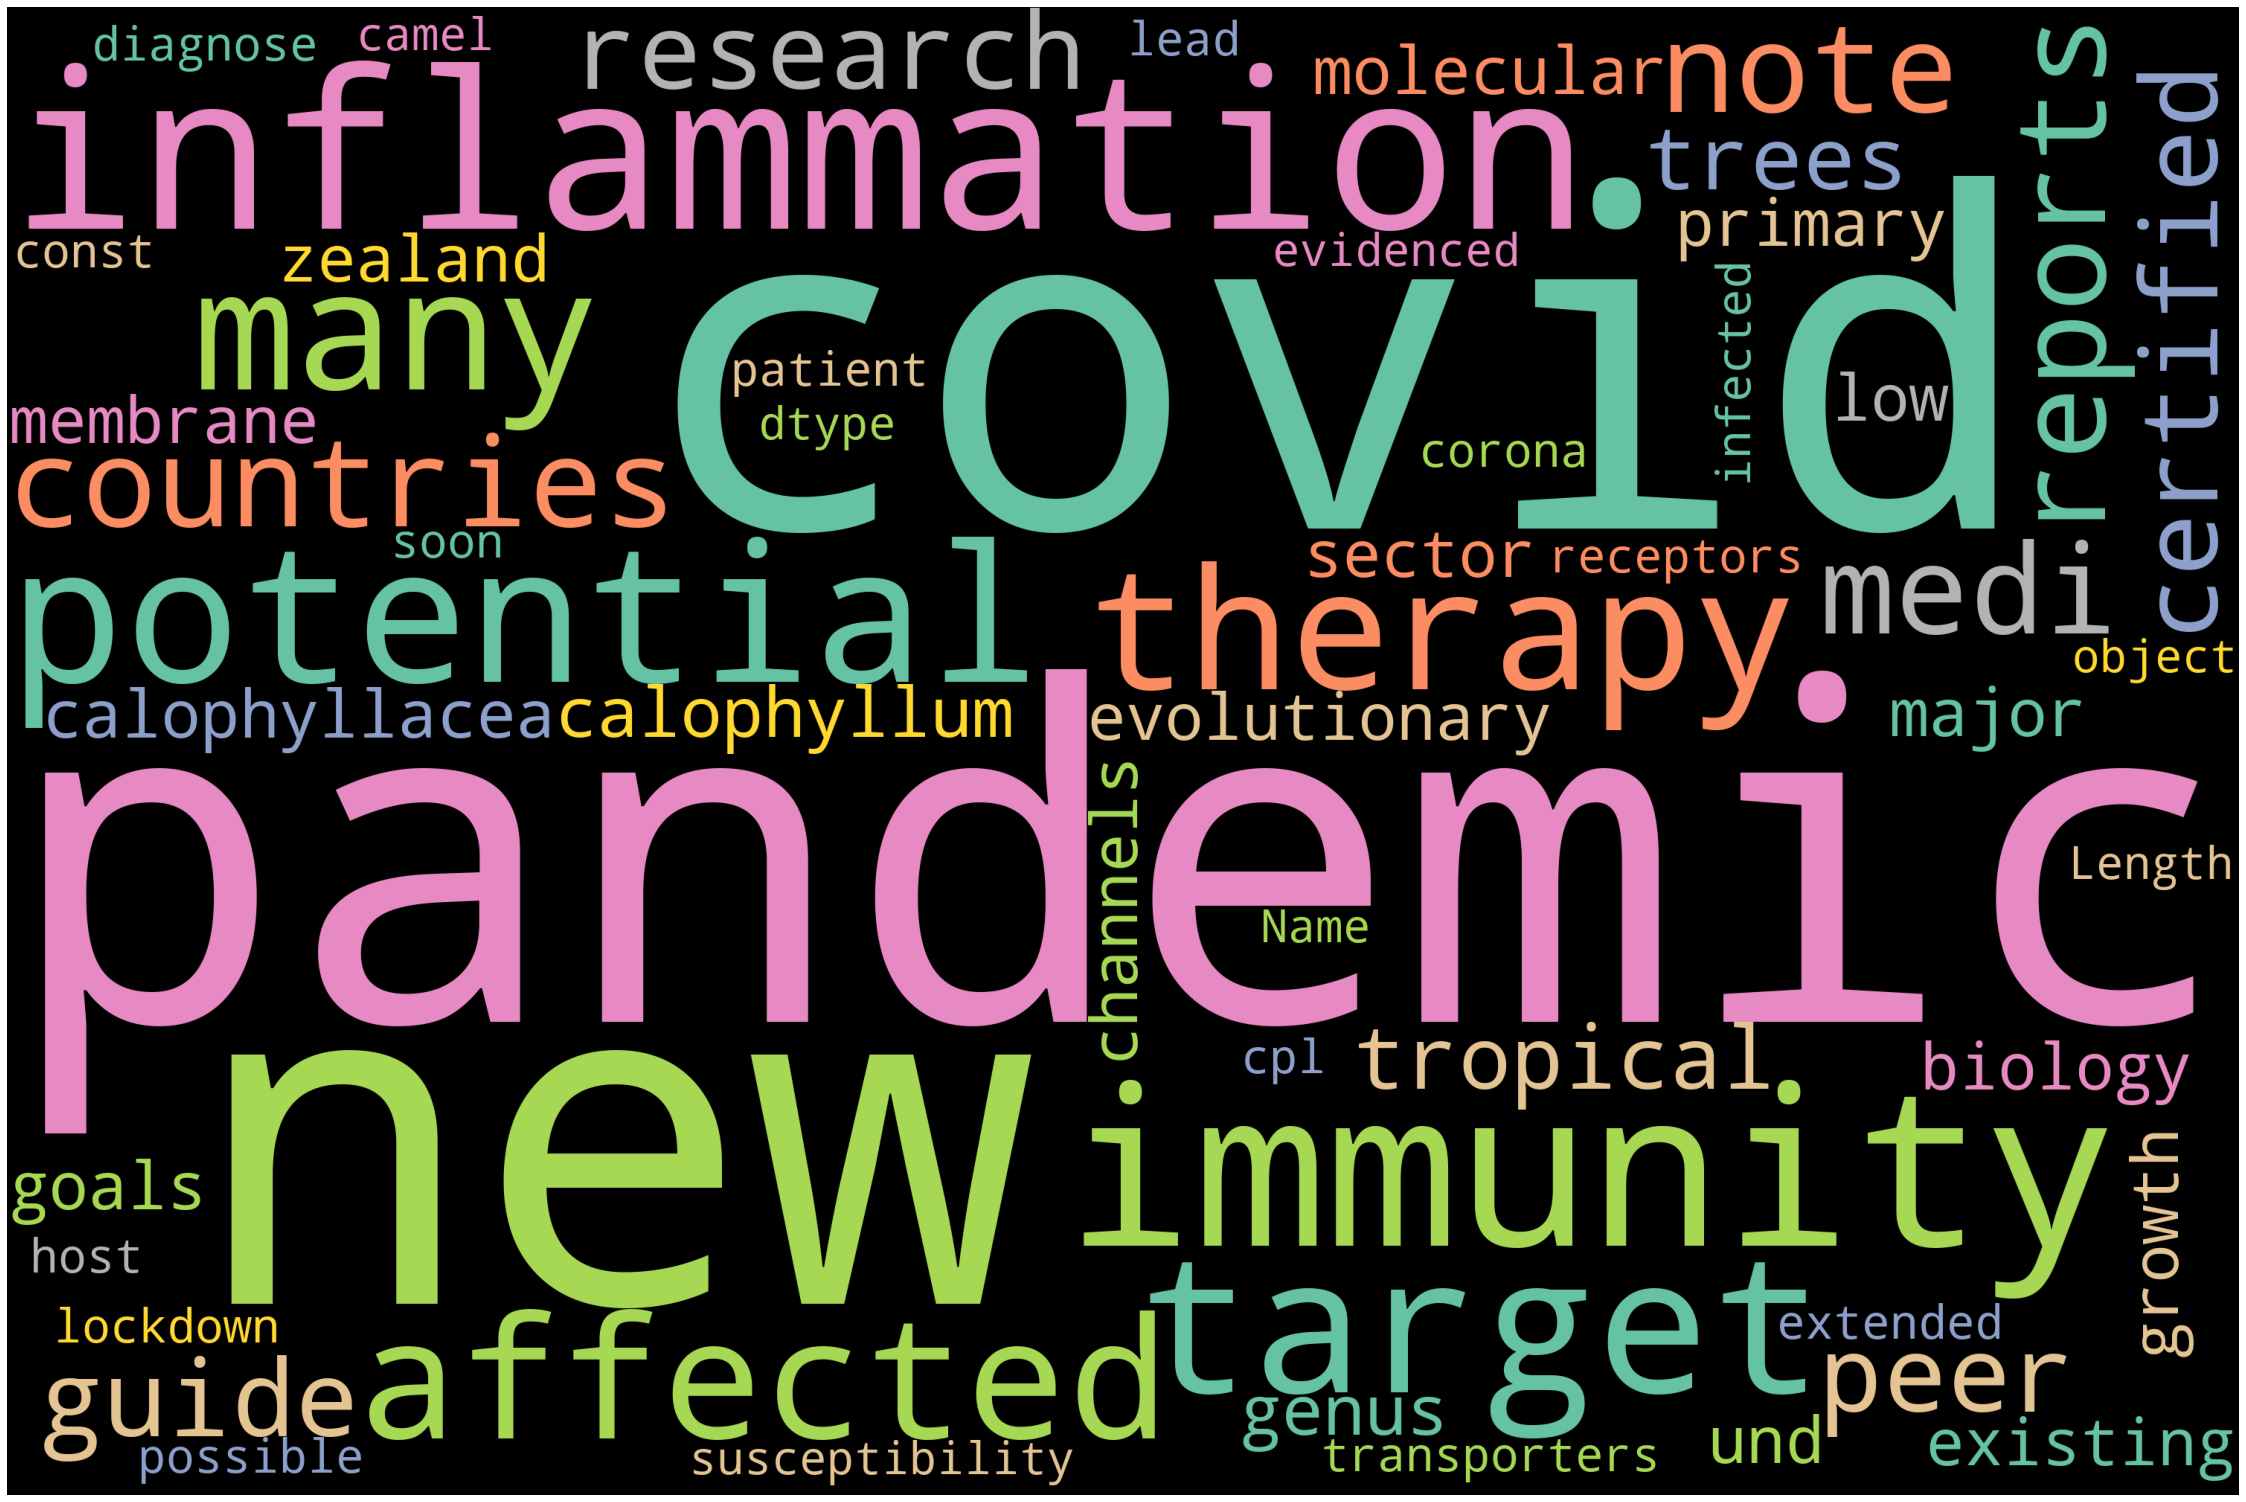

In [ ]:
abstract_text = str(df.abstract)

# Import package
from wordcloud import WordCloud
# Generate word cloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='Set2', collocations=False, stopwords = stopwords_custom).generate(abstract_text)
# Plot
plot_cloud(wordcloud)

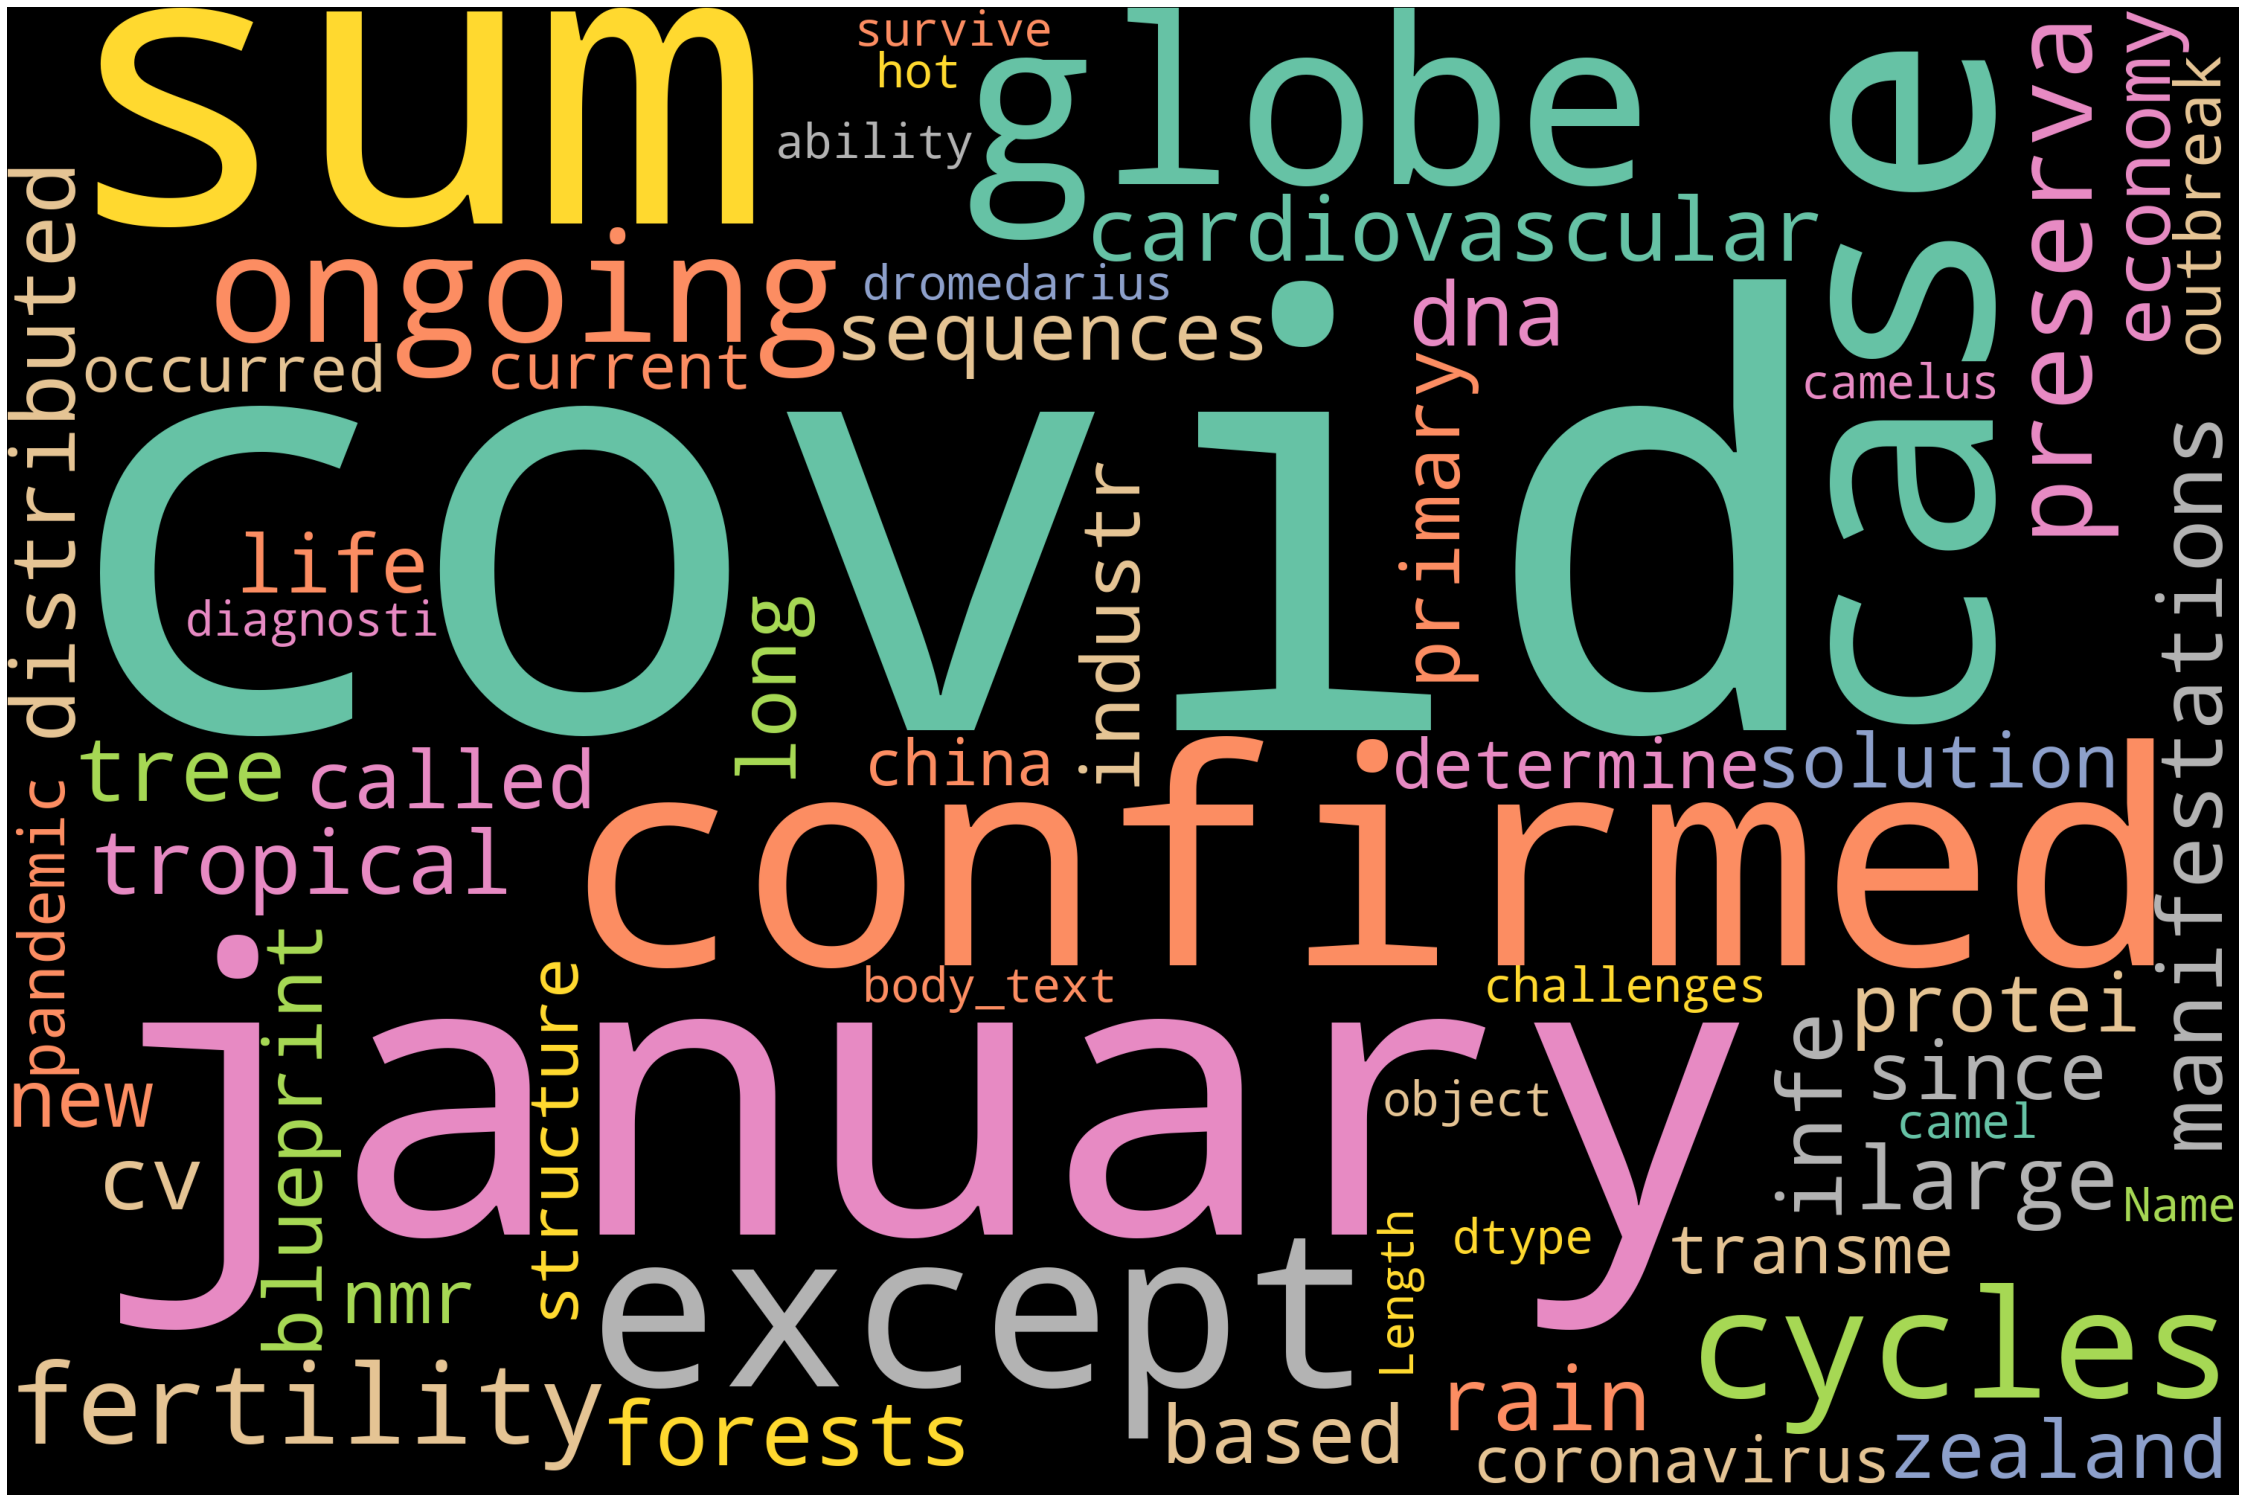

In [ ]:
text = str(df.body_text)

# Import package
from wordcloud import WordCloud
# Generate word cloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='Set2', collocations=False, stopwords = stopwords_custom).generate(text)
# Plot
plot_cloud(wordcloud)

vocabulary size

In [ ]:
Total_astract_words = df["abstract_word_count"].sum()
Total_body_words = df["body_word_count"].sum()

In [ ]:
print("Total_astract_words:  " , Total_astract_words)

Total_astract_words:   101861


In [ ]:
print("Total_body_words:  ", Total_body_words)

Total_body_words:   1822226


In [ ]:
Total_words = Total_astract_words  + Total_body_words
print("Total_words: ",Total_words)

Total_words:  1924087


In [ ]:
dataframe = df.copy()

dataframe


,paper_id,abstract,body_text,abstract_word_count,body_word_count,body_unique_words
0,173417343f37c299df8c0fe888cf316b78630e16,inflammation immunity potential target therapy...,january 26 2021 sum 100 346 160 confirmed case...,46,4337,1491
1,19591d13b1530344fb152de55901f77b043b6a1f,pandemic covid 19 affected many countries medi...,globe except ongoing cycles fertility preserva...,243,3733,1261
2,25bcee9d98126a730a011cc3147668ffe935520e,note reports new research certified peer guide...,cardiovascular cv manifestations covid 19 infe...,2075,11456,2353
3,05cfa842a87231c5c2871d2194835709b02bc046,tropical trees calophyllum genus calophyllacea...,large tree tropical rain forests distributed m...,240,2504,1000
4,250d59ab75d8f45de88ab498f3483ead9d13be63,major goals molecular evolutionary biology und...,dna sequences called the blueprint life protei...,126,11817,2502
...,...,...,...,...,...,...
425,5978ed61b14091115851ab1409069f55551ba114,new zealand existing primary sector growth low...,new zealand long economy based primary industr...,317,5199,1836
426,02dbd61a09c3a529e687ae3780e82f5742e222e8,membrane channels transporters receptors const...,since solution nmr determine structure transme...,150,3010,1198
427,23ce5b54778898d2c19e605d8cc6ac6038493c7b,diagnose infected patient soon possible corona...,coronavirus outbreak covid 19 occurred china d...,237,4300,1183
428,0b9e7451552da6af9d62fb0cb98958f17087f7b4,background covid 19 pandemic lockdown cpl lead...,current covid 19 pandemic challenges diagnosti...,254,3713,1335


In [ ]:
# Count of all tokens in the columns and unique words in the columns
df['abstract_word_count'] = df['abstract'].apply(lambda x: len(x.strip().split()))  # word count in abstract
df['body_word_count'] = df['body_text'].apply(lambda x: len(x.strip().split()))  # word count in body
df['body_unique_words']=df['body_text'].apply(lambda x:len(set(str(x).split())))  # number of unique words in body
df['abstract_unique_words'] = df['abstract'].apply(lambda x:len(set(str(x).split())))
df.head()


,paper_id,abstract,body_text,abstract_word_count,body_word_count,body_unique_words,abstract_unique_words
0,173417343f37c299df8c0fe888cf316b78630e16,inflammation immunity potential target therapy...,january 26 2021 sum 100 346 160 confirmed case...,37,2856,1185,33
1,19591d13b1530344fb152de55901f77b043b6a1f,pandemic covid 19 affected many countries medi...,globe except ongoing cycles fertility preserva...,162,2461,977,132
2,25bcee9d98126a730a011cc3147668ffe935520e,note reports new research certified peer guide...,cardiovascular cv manifestations covid 19 infe...,1397,7452,1531,604
3,05cfa842a87231c5c2871d2194835709b02bc046,tropical trees calophyllum genus calophyllacea...,large tree tropical rain forests distributed m...,149,1640,754,94
4,250d59ab75d8f45de88ab498f3483ead9d13be63,major goals molecular evolutionary biology und...,dna sequences called the blueprint life protei...,77,7424,1813,62


Heaps' Law The law can be described like as the number of words in a document increases, the rate of the count of distinct words available in the document slows down.

The documented definition of Heaps’ law (also called Herdan's law) says that the number of unique words in a text of n words is approximated by

V(n) = K n^β

where K is a positive constant and β is between 0 and 1. K is often upto 100 and β is often between 0.4 an 0.6

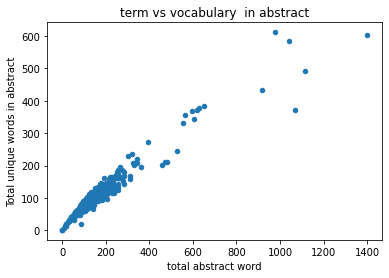

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# a scatter plot comparing total words in abstarct vs unique words in abstract

df.plot(kind = "scatter" , x="abstract_word_count" , y="abstract_unique_words")
plt.title("term vs vocabulary  in abstract")
plt.xlabel("total abstract word")
plt.ylabel("Total unique words in abstract")
plt.show()

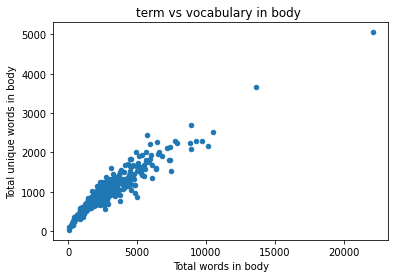

In [ ]:
df.plot(kind = "scatter" , x="body_word_count" , y="body_unique_words")
plt.title("term vs vocabulary in body ")
plt.xlabel("Total words in body")
plt.ylabel("Total unique words in body")
plt.show()

using heaps law

In [ ]:
import math
# here b  and k comes after calculation 
b = 0.6511
k = 0.8

To predict that we first have to calculate the constant value K and β, for that we make use of the calculated value of V(n) and n and put that in V(n) = K n^β

V(n) = K n^β => log V(n) = β log(n) + K

In [ ]:
X = df["body_word_count"].values
y = df["body_unique_words"].values

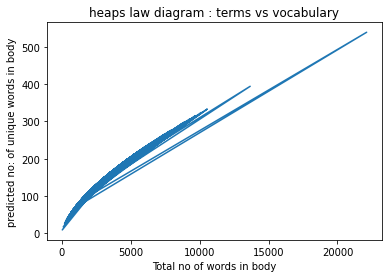

In [ ]:

Y = k*(X)**b
plt.title("heaps law diagram : terms vs vocabulary")

plt.xlabel("Total no of words in body")
plt.ylabel("predicted no: of unique words in body")
plt.plot(X,Y)

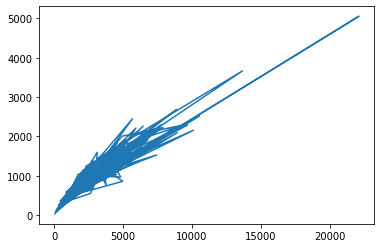

In [ ]:
plt.plot(X,y)


As we can see in above graph we have shown terms vs vocabulary using heaps law .Thus it predicts no of unique words given no of words and calculated b and k from above formulae.

In [ ]:
from google.colab import  drive

#Mounts the google drive to Colab Notebook
drive.mount('/drive')

#Make sure the folder Name is created in the google drive before uploading
df.to_csv('/drive/My Drive/nlp corpus/corpus.csv')

Mounted at /drive
